In [1]:
WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysis/"
import sys; sys.path.append(f"{WORKDIR}/libPython")
from sklearn.utils import shuffle
from ROOT import TFile
import torch
from torch_geometric.loader import DataLoader

from Preprocess import GraphDataset
from Preprocess import rtfileToDataListV2
from Models import ParticleNetV2

Welcome to JupyROOT 6.28/00


In [35]:
CHANNEL = "Skim3Mu"
SIGNAL = "MHc-160_MA-85"
BACKGROUND = "nonprompt"
NHIDDEN = 128
OPTIMIZER = "Adam"
INITLR = 0.001
SCHEDULER = "CyclicLR"

maxSize = -1
# load dataset
if CHANNEL == "Combined":
    rtSig = TFile.Open(f"{WORKDIR}/data/DataPreprocess/Combined/Skim1E2Mu__/{SIGNAL}.root")
    sigDataList1E2Mu = shuffle(rtfileToDataListV2(rtSig, isSignal=True, maxSize=maxSize), random_state=953); rtSig.Close()
    rtSig = TFile.Open(f"{WORKDIR}/data/DataPreprocess/Combined/Skim3Mu__/{SIGNAL}.root")
    sigDataList3Mu = shuffle(rtfileToDataListV2(rtSig, isSignal=True, maxSize=maxSize), random_state=953); rtSig.Close()
    sigDataList = shuffle(sigDataList1E2Mu+sigDataList3Mu, random_state=953)

    rtBkg = TFile.Open(f"{WORKDIR}/data/DataPreprocess/Combined/Skim1E2Mu__/{BACKGROUND}.root")
    bkgDataList1E2Mu = shuffle(rtfileToDataListV2(rtBkg, isSignal=False, maxSize=maxSize), random_state=953); rtBkg.Close()
    rtBkg = TFile.Open(f"{WORKDIR}/data/DataPreprocess/Combined/Skim3Mu__/{BACKGROUND}.root")
    bkgDataList3Mu = shuffle(rtfileToDataListV2(rtBkg, isSignal=False, maxSize=maxSize), random_state=953); rtBkg.Close()
    bkgDataList = shuffle(bkgDataList1E2Mu+bkgDataList3Mu, random_state=953)
else:
    rtSig = TFile.Open(f"{WORKDIR}/data/DataPreprocess/Combined/{CHANNEL}__/{SIGNAL}.root")
    rtBkg = TFile.Open(f"{WORKDIR}/data/DataPreprocess/Combined/{CHANNEL}__/{BACKGROUND}.root")

    sigDataList = shuffle(rtfileToDataListV2(rtSig, isSignal=True), random_state=953); rtSig.Close()
    bkgDataList = shuffle(rtfileToDataListV2(rtBkg, isSignal=False), random_state=953); rtBkg.Close()
dataList = shuffle(sigDataList+bkgDataList, random_state=42)

trainset = GraphDataset(dataList[:int(len(dataList)*0.5)])
validset = GraphDataset(dataList[int(len(dataList)*0.5):int(len(dataList)*0.7)])
testset  = GraphDataset(dataList[int(len(dataList)*0.7):])

trainLoader = DataLoader(trainset, batch_size=1024, pin_memory=True, shuffle=True)
validLoader = DataLoader(validset, batch_size=1024, pin_memory=True, shuffle=False)
testLoader = DataLoader(testset, batch_size=1024, pin_memory=True, shuffle=False)

@@@@ no. of dataList ends with 140000
@@@@ no. of dataList ends with 140000


In [43]:
nFeatures = 9
nGraphFeatures = 3
nClasses = 2

model = ParticleNetV2(nFeatures, nGraphFeatures, nClasses, NHIDDEN, 0.4)
modelPath = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIGNAL}_vs_{BACKGROUND}/models/ParticleNet-nNodes{NHIDDEN}_{OPTIMIZER}_initLR-{str(INITLR).replace('.', 'p')}_{SCHEDULER}.pt"
model.load_state_dict(torch.load(modelPath, map_location=torch.device('cpu')))
model.eval()

ParticleNetV2(
  (gn0): GraphNorm(9)
  (bn0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): DynamicEdgeConv()
  (conv2): DynamicEdgeConv()
  (conv3): DynamicEdgeConv()
  (dense1): Linear(in_features=131, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [44]:
# Prepare histograms
from ROOT import TH1D
hSigTrain = TH1D("hSigTrain", "", 1000, 0., 1.)
hBkgTrain = TH1D("hBkgTrain", "", 1000, 0., 1.)
hSigTest = TH1D("hSigTest", "", 1000, 0., 1.)
hBkgTest = TH1D("hBkgTest", "", 1000, 0., 1.)

Warning in <TROOT::Append>: Replacing existing TH1: hSigTrain (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hBkgTrain (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hSigTest (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hBkgTest (Potential memory leak).


In [45]:
with torch.no_grad():
    for data in trainLoader:
        scores = model(data.x, data.edge_index, data.graphInput, data.batch)
        for idx, score in enumerate(scores):
            score = score[1].numpy()
            isSignal = data.y[idx] == 1
            if isSignal: hSigTrain.Fill(score)
            else:        hBkgTrain.Fill(score)
            
    for data in testLoader:
        scores = model(data.x, data.edge_index, data.graphInput, data.batch)
        for idx, score in enumerate(scores):
            score = score[1].numpy()
            isSignal = data.y[idx] == 1
            if isSignal: hSigTest.Fill(score)
            else:        hBkgTest.Fill(score)

In [46]:
# scale distribution
hSigTrain.Scale(1./hSigTrain.Integral())
hSigTest.Scale(1./hSigTest.Integral())
hBkgTrain.Scale(1./hBkgTrain.Integral())
hBkgTest.Scale(1./hBkgTest.Integral())

In [47]:
ksprobSig = hSigTrain.KolmogorovTest(hSigTest, option="X")
ksprobBkg = hBkgTrain.KolmogorovTest(hBkgTest, option="X")
print(ksprobSig, ksprobBkg)

0.189 0.001


In [48]:
from ROOT import TCanvas
hBkgTrain.Scale(1./hBkgTrain.Integral())
hBkgTest.Scale(1./hBkgTest.Integral())

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


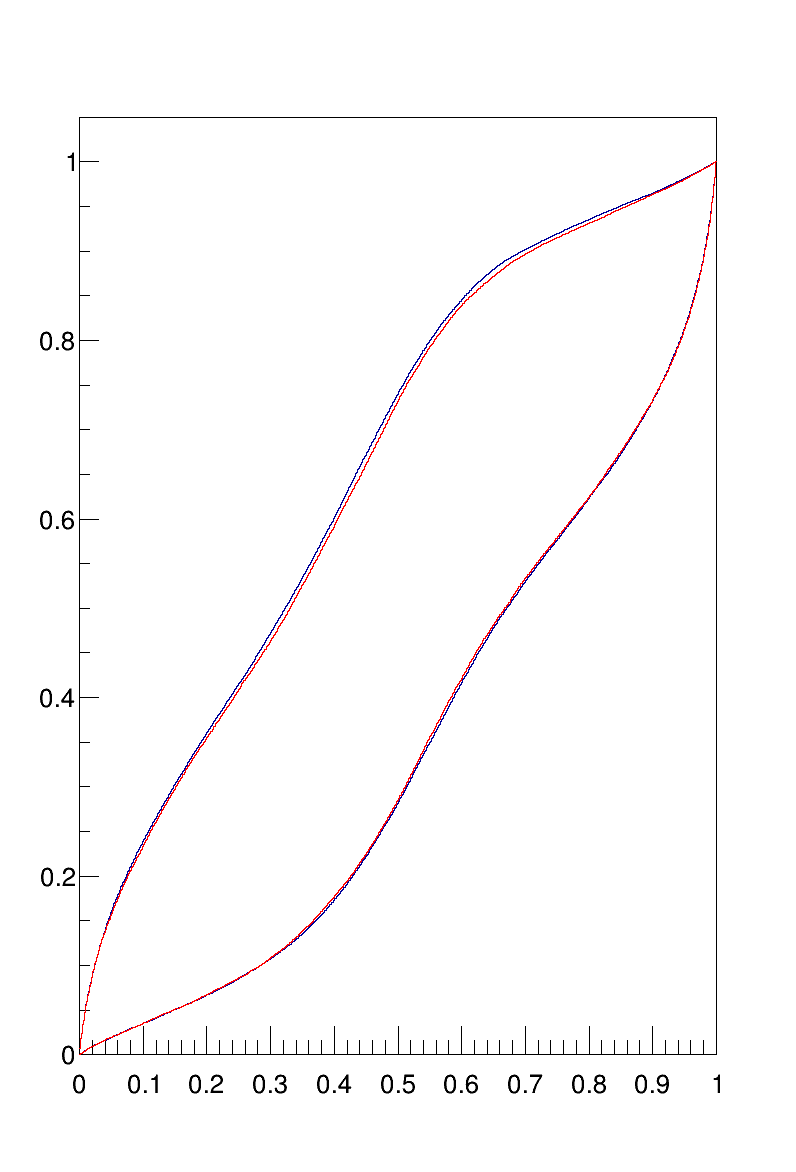

In [49]:
import ROOT
from ROOT import TCanvas

hSigTrainCum = hSigTrain.GetCumulative()
hSigTestCum = hSigTest.GetCumulative()

hBkgTrainCum = hBkgTrain.GetCumulative()
hBkgTestCum = hBkgTest.GetCumulative()

hSigTestCum.SetLineColor(ROOT.kRed)
hBkgTestCum.SetLineColor(ROOT.kRed)

hSigTrainCum.SetStats(0)
hBkgTrainCum.SetStats(0)
c = TCanvas("c", "", 800, 1200)
c.cd()
#c.SetLogy()
hSigTrainCum.Draw("hist")
hSigTestCum.Draw("same&hist")
hBkgTrainCum.Draw("same&hist")
hBkgTestCum.Draw("same&hist")
c.Draw()